# Read in the data

In [1]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt
%matplotlib inline 

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

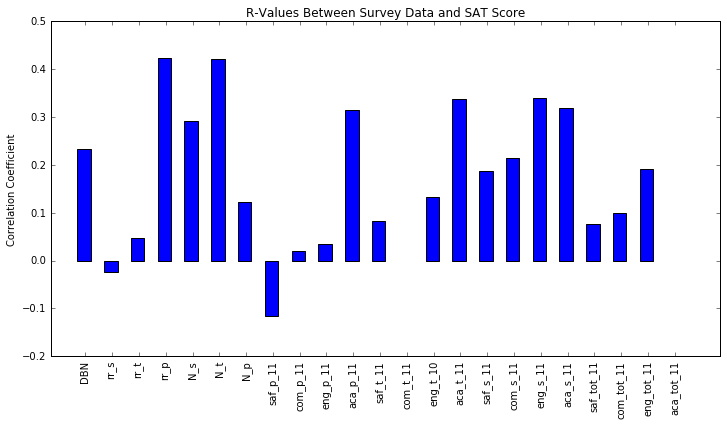

[        nan  0.23219913 -0.02338629  0.04792452  0.42346295  0.29146303
  0.42153003  0.12291284 -0.11507348  0.02025411  0.03515462  0.31381033
  0.08241942         nan  0.13234767  0.33763874  0.1873702   0.21382161
  0.33943547  0.31875345  0.0773102   0.10010183  0.19096598]


In [10]:
from numpy import arange
bar_pos = arange(len(survey_fields))
bar_hgts = correlations[survey_fields].values

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(bar_pos, bar_hgts, 0.5)
ax.set_xticks(bar_pos + 1.3)
ax.set_xticklabels(survey_fields, rotation=90)
ax.set_ylabel('Correlation Coefficient')
ax.set_title('R-Values Between Survey Data and SAT Score')
plt.show()
print(bar_hgts)

There are several interesting things we can notice here. 
(I) The response rate of teachers and students don't correlate to higher SAT scores, but the response rate of parents show a strong correlation.
(II) This relationship actually flips when we consider the number of respondants. The number of student and teacher respondants show positive-strong correlations whereas the number of parent respondants are not very strongly correlated.
(III) Academic expectations show strong-positive correlation for teachers, parents, and students.
(IV) Engagement score correlates strong-positively with students, weak-positively with teachers, and shows no correlation with parents.
(V) We also notice that when students and teachers feel safer at school, the students get higher SAT scores

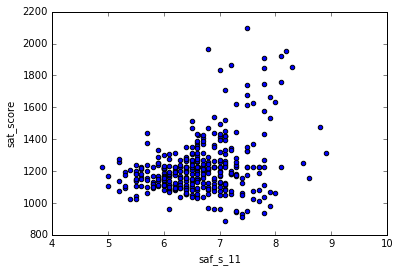

In [11]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

We can see from the above plot that there is a positive correlation between student safety and student SAT performance

In [12]:
a_s = combined.groupby('school_dist')['saf_s_11'].mean()

In [13]:
def get_safety_score(district):
    return a_s[district]

combined['avg_safety'] = combined['school_dist'].apply(get_safety_score)

In [14]:
combined.reset_index('DBN')

,index,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,...,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist,avg_safety
0,0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.000000,404.000000,363.000000,1122.000000,0,129.028846,...,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01,6.768611
1,1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.000000,423.000000,366.000000,1172.000000,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,...,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01,6.768611
2,2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.000000,402.000000,370.000000,1149.000000,EAST SIDE COMMUNITY HS,19.000000,...,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041,01,6.768611
3,3,01M509,MARTA VALLE HIGH SCHOOL,44,390.000000,433.000000,384.000000,1207.000000,0,129.028846,...,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673,01,6.768611
4,4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.000000,574.000000,525.000000,1621.000000,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,...,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426,01,6.768611
5,5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.000000,604.000000,628.000000,1856.000000,0,129.028846,...,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01,6.768611
6,6,02M047,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,16,395.000000,400.000000,387.000000,1182.000000,0,129.028846,...,0,0,0,0,0,"223 East 23 Street\nNew York, NY 10010\n(40.73...",40.738599,-73.982512,02,6.910660
7,7,02M288,FOOD AND FINANCE HIGH SCHOOL,62,409.000000,393.000000,392.000000,1194.000000,0,129.028846,...,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02,6.910660
8,8,02M294,ESSEX STREET ACADEMY,53,394.000000,384.000000,378.000000,1156.000000,0,129.028846,...,0,0,0,0,0,"350 Grand Street\nNew York, NY 10002\n(40.7168...",40.716867,-73.989532,02,6.910660
9,9,02M296,HIGH SCHOOL OF HOSPITALITY MANAGEMENT,58,374.000000,375.000000,362.000000,1111.000000,High School of Hospitality Management,129.028846,...,0,0,0,0,0,"525 West 50Th Street\nNew York, NY 10019\n(40....",40.765027,-73.992517,02,6.910660


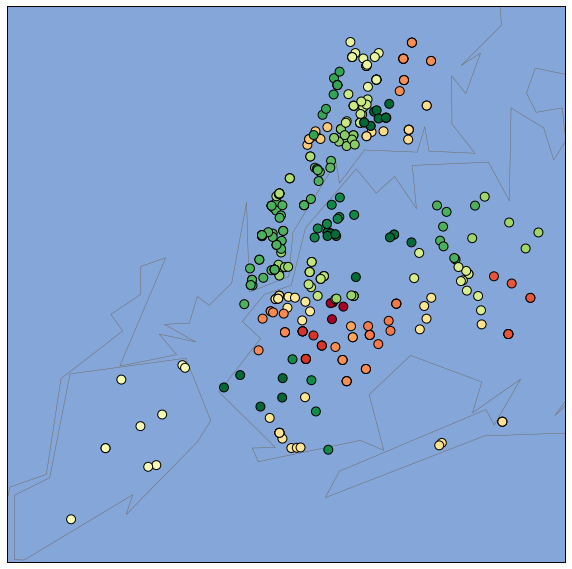

In [22]:
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(10,10))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = combined['lon'].tolist()
latitudes = combined['lat'].tolist()

m.scatter(longitudes, latitudes, s=80, zorder=2, latlon=True, c=combined['avg_safety'], cmap='RdYlGn')
plt.show()

The above plot is colored such that green indicates high safety, yellow indicates medium safety, and red indicates low safety. From this, we see that Manhattan, the Southern part of Bronx, and the Northern part of Queens have relatively high feelings of safety as well as some schools in Southern Brooklyn. Northern and central Brooklyn, however, are particularly rated as unsafe schools.

In [34]:
race = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

correlations = combined.corr()
correlations = correlations['sat_score']
race_corr = []
for r in race:
    race_corr.append(correlations[r])

print(race_corr)

[0.62071776385268018, 0.57073022002148721, -0.2841394684581478, -0.39698493078147196]


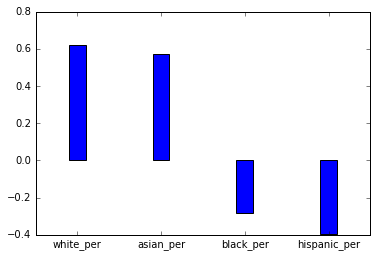

In [50]:
bar_pos = numpy.arange(4)

fig, ax = plt.subplots()
ax.bar(bar_pos + 0.4, race_corr, 0.2)
ax.set_xticks(bar_pos + 0.5)
ax.set_xticklabels(race)
ax.set_xlim(0,4)
plt.show()

We see that schools with higher percentages of whites and asians have positive-strong correlations with SAT scores. The opposite is true of schools with higher percentages of blacks and hispanics.

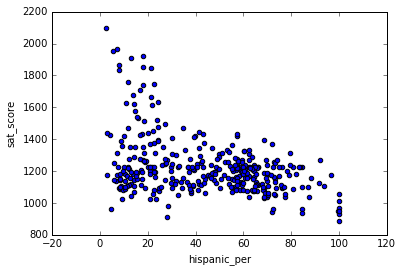

In [52]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

We see here that there is a negative correlation between SAT scores and hispanic student percentage

In [53]:
isabove95 = combined['hispanic_per'] > 95

In [55]:
over95hispanic = combined[isabove95]

In [63]:
print(over95hispanic['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools seem to be meant for those students who speak English as a second language. As we discovered earlier, schools such as these tend to perform poorly on the SAT

In [59]:
isbelow10 = combined['hispanic_per'] < 10
over1800 = combined['sat_score'] > 1800
g = combined[isbelow10 & over1800]

In [62]:
print(g['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


These schools with high SAT scores and low hispanic populations are all STEM focused schools. While they are still public, they are specialized and more selective than other schools.

In [64]:
correlations = combined.corr()
correlations = correlations['sat_score']

<Container object of 2 artists>

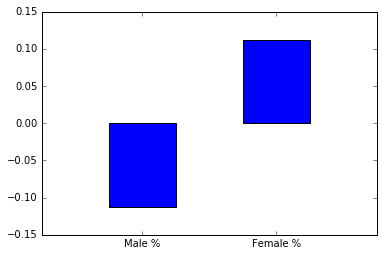

In [82]:
bar_pos = [0.1, 0.3]
vals = correlations[['male_per', 'female_per']]
fig, ax = plt.subplots()
ax.set_xlim(0,0.5)
ax.set_xticks([0.15, 0.35])
ax.set_xticklabels(['Male %', 'Female %'])
ax.bar(bar_pos, vals, .1)

We can see that schools with more girls fare better on the SAT than schools with more boys

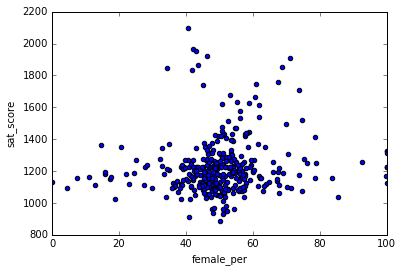

In [84]:
combined.plot.scatter(x='female_per', y='sat_score', xlim=(0,100))

We can see from this plot that a majority of schools have ~%50 female students, which is expected. We can also see a weak-positive correlation between sat_score and female percentage. However, there are a cluster of schools that have ~%40 female students that performed exceptionally high on the SAT. It would be interesting to see why that is the case.

In [85]:
isover1700 = combined['sat_score'] > 1700
islessthan50 = combined['female_per'] < 50
g = combined[isover1700 & islessthan50]

In [87]:
print(g['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
198                           BROOKLYN LATIN SCHOOL, THE
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It appears that these are the technical schools and specialized schools we found earlier when considering hispanic population.

In [88]:
isover60 = combined['female_per'] > 60
g = combined[isover1700 & isover60]
print(g['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


It seems that these high schools are exceptionally good schools to get into. They focus on college prep work and are all highly regarded schools

In [90]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

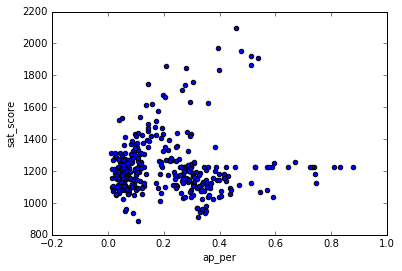

In [91]:
combined.plot.scatter(x='ap_per', y='sat_score')

The scatterplot shows a couple of interesting things. There seems to be a weak-positive correlation between ap_per and sat_score unti the ap_per value approaches 0.6. Then it seems that there is no correlation at all between the two fields. There are several explanations. Perhaps more students are likely to take an AP exam if a subject is easy, which would mean that even if a student was likely to perform poorly, they would still attempt an AP test. Maybe some high schools push students into taking the AP test even if the student isn't motivated. Also, performing poorly on an AP test does not cause any negative consequences aside from missing out on potential college credit. So it could be that students just try every AP test they can regardless of whether or not they think they'll perform well.